# Diffusion 扩散模型 之 Score Matching

这是 diffusion 扩散模型系列第一部分，我们将从最基础的 score matching入手，这将帮助我们深刻理解 diffusion 模型的发展历程。

本部分包括以下内容：
  1. Score Matching
  2. Sliced Score Matching
  3. Denoising Score Matching
  
笔记参考：https://github.com/acids-ircam/diffusion_models

## 1 Score matching

Diffusion 使用 Energy-based models：
$$
p_\theta(\mathbf{x})=\frac{e^{f_\theta}(\mathbf{x})}{Z(\theta)}
$$

式中，$p_\theta(\mathbf{x})$ 必须是 normalized 概率密度函数，即：$\int p_\theta(\mathbf{x})\mathsf{d} \mathbf{x}=1$

为了满足 normalized 条件，需要对模型引入额外的约束，使得 $Z_\theta$ tractable，为了摆脱此限制，引出$p_\theta (\mathbf{x})$ 的 score function：

$$
\nabla_\mathbf{x} \log p_\theta(\mathbf{x})
$$
score-based 模型目标是学习 $\mathbf{s}_\theta(\mathbf{x})\approx \nabla_\mathbf{x} \log p_\theta(\mathbf{x})$


$$
\begin{equation}
\mathbf{s}_\theta (\mathbf{x}) = \nabla_{\mathbf{x}} \log p_\theta (\mathbf{x} ) = -\nabla_{\mathbf{x}}  f_\theta (\mathbf{x}) - \underbrace{\nabla_\mathbf{x} \log Z_\theta}_{=0} = -\nabla_\mathbf{x} f_\theta(\mathbf{x}).
\end{equation}
$$
由上式可见：$\mathbf{s}_\theta(\mathbf{x})$ 独立于 normalizing constant $Z_\theta$，不用担心 normalization 问题。

接下来的问题是如何得到模型 $\mathbf{s}_\theta(\mathbf{x})$？Score matching 方法可以解决该问题。

Score Matching 的想法来源于 Hyvarinen et al. [ [ 6 ] ](#ref6)。不同于直接学习数据分布 $\log p(\mathbf{x})$, 我们的目标是学习 $\log p(\mathbf{x})$ 关于 $x$ 的梯度。

在此情况下,$\nabla_{\mathbf{x}} \log p_\theta (\mathbf{x})$ 是概率密度 $p(\mathbf{x})$ 的分数(score), 所以称之为 score matching。这可以被理解为学习输入空间中每个点的最大概率的方向，当模型训练好之后，我们可以将样本向最大概率的方向移动，以此来改进样本。


为了方便理解，使用数据集 swiss roll 来做分析：


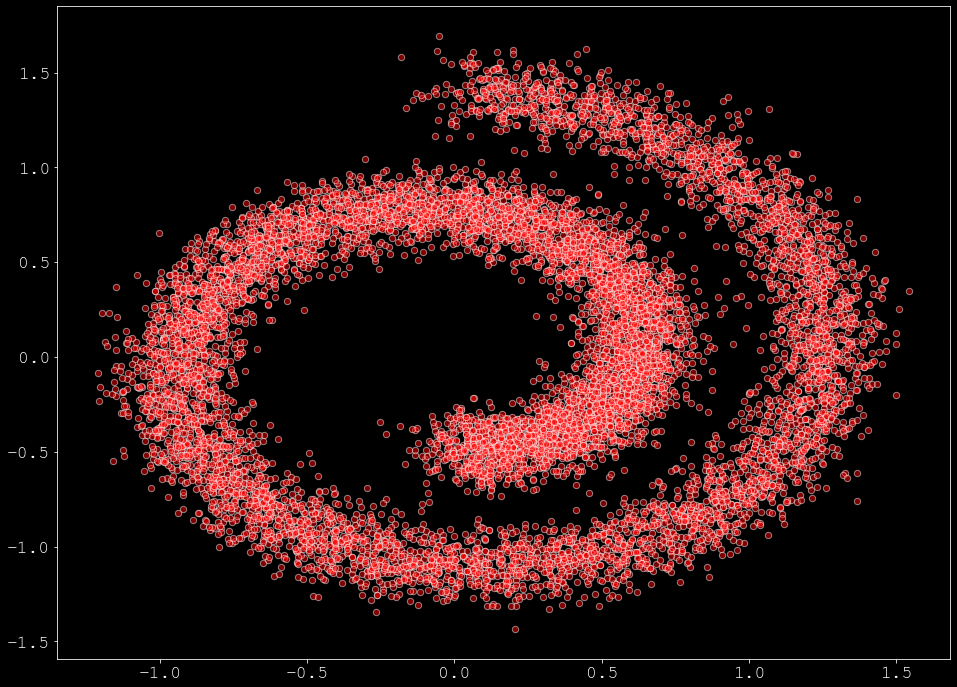

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from plots import hdr_plot_style

hdr_plot_style()

# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

为了训练, 我们需要最小化 $\mathcal{F}_{\theta}(\mathbf{x})$ 与 $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 的误差, 损失函数可以是 Fisher divergence 或者简单的 MSE：

$$ \mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right] $$

真实的 $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 通常是未知的, 对 $p(\mathbf{x})$ 做一些假设, 最小化 $\mathcal{L}_{mse}$ 等同于最小化如下目标函数：

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

式中 $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ 表示 $\mathcal{F}_{\theta}(\mathbf{x})$ 关于 $\mathbf{x}$ 的 Jacobian,  $ \text{tr}(\cdot) $ 是 _trace_ 运算。

为了进行优化, 我们可以使用 `Pytorch` 搭建 $\mathcal{F}_{\theta}(\mathbf{x})$ 的神经网络。

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

接下来, 我们需要定义 _score matching_ 目标的损失函数。

首先计算 Jacobian, 我们需要定义一个特别的 (可微分) 函数，这个高效的执行方式是基于这个讨论 [here](https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa)。

In [7]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

Score Matching 损失函数的计算分为：  首先计算 $\frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2$，然后计算 $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \right)$ ， 最后返回两者之和。

In [8]:
def score_matching(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

运行代码训练模型：

In [9]:
dataset = torch.tensor(data.T).float()
for t in range(2000):
    # Compute the loss.
    loss = score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 500) == 0):
        print(loss)

tensor(-0.0388, grad_fn=<MeanBackward1>)
tensor(-19.0463, grad_fn=<MeanBackward1>)
tensor(-42.7619, grad_fn=<MeanBackward1>)
tensor(-49.5301, grad_fn=<MeanBackward1>)


绘制输入空间中的输出，可以看出模型能学到 $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ 。

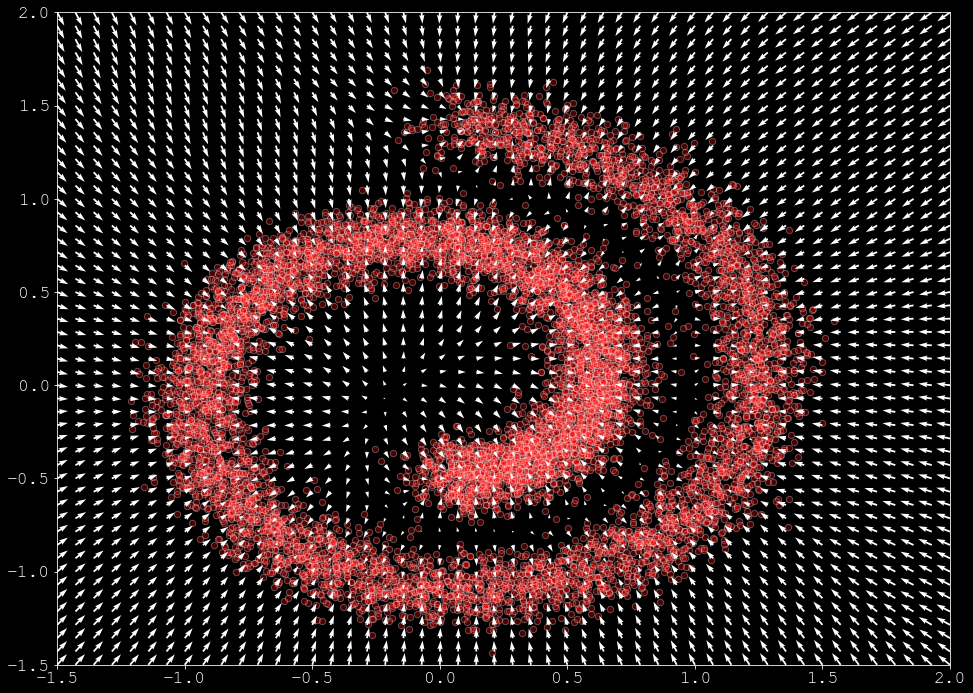

In [10]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

## 2 Sliced Score Matching

前面定义的 _score matching_ 方法不适用于高维数据, 或者深度网络。

因为 $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$ 的计算量十分大， Jacobian计算量为 $O(N^2 + N)$ , 即使使用前面的优化代码，也无法计算高维数据。 

最近, Song et al. [ [ 7 ] ](#ref7) 提出随机投影的方法来近似计算 score matching 中的 $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$ 。 这个方法称为 Sliced Score Matching ，此时优化目标变成：

$$ E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

式中, $\mathbf{v} \sim \mathcal{N}(0, 1)$ 是正太分布向量。可以使用前向过程 auto-differentiation 来高效计算。

In [13]:
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

损失函数的优化示例如下：

In [14]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T)[:1000].float()
for t in range(2000):
    # Compute the loss.
    loss = sliced_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 500) == 0):
        print(loss)

tensor(0.0359, grad_fn=<MeanBackward1>)
tensor(-0.7544, grad_fn=<MeanBackward1>)
tensor(-5.5483, grad_fn=<MeanBackward1>)
tensor(-9.4079, grad_fn=<MeanBackward1>)


使用前面定义的可视化函数检查结果：

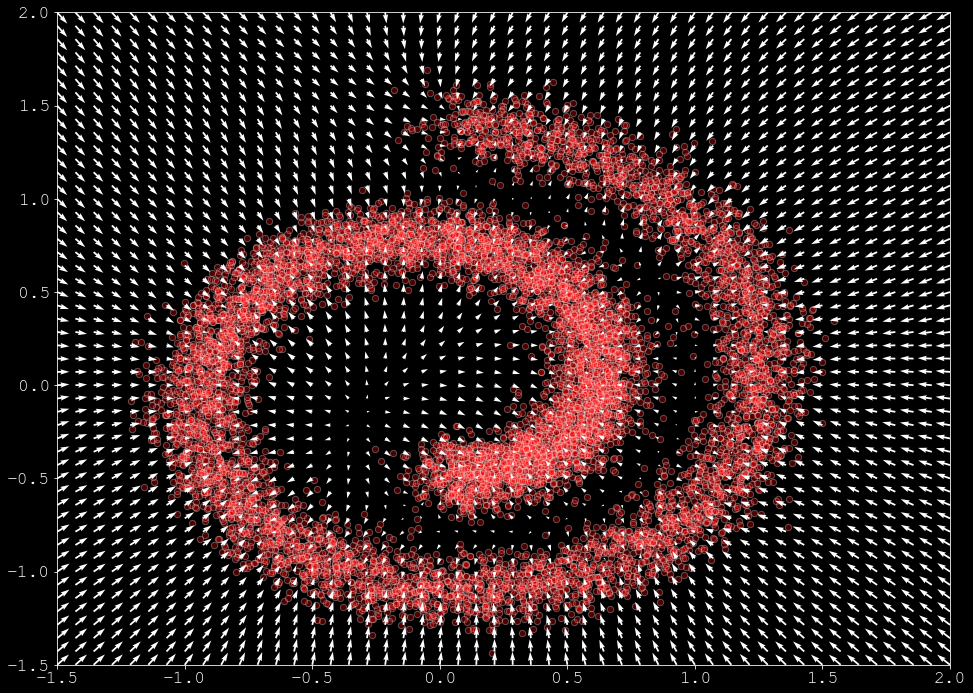

In [15]:
plot_gradients(model, data)

## 3 Denoising Score Matching

 Denoising Score Matching 最初由 Vincent [ [ 3 ] ](#ref3) 在 denoising auto-encoders 中提出，可以完全取消 $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$ 在 score matching 中的计算。 
 
 首先需要使用给定的噪声向量污染数据 $\mathbf{x}$ , 得到分布 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$。 然后用 score matching 来预测 **扰动之后数据分布的 score**。 
 
 最优网络 $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ 可以通过最小化如下目标获得：

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

值得注意的是当噪声足够小$q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$ ，此时 $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ 才成立。

如果我们选择噪声分布为 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, 则有 $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = -\frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$。

因此 denoising score matching 的损失函数可以简化为：

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

Denoising Score Matching 的损失函数计算如下：

In [16]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

使用同样的模型和优化器：

In [17]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(10038.9043, grad_fn=<MulBackward0>)
tensor(10094.2500, grad_fn=<MulBackward0>)
tensor(9993.1592, grad_fn=<MulBackward0>)
tensor(10031.3828, grad_fn=<MulBackward0>)
tensor(9829.4570, grad_fn=<MulBackward0>)


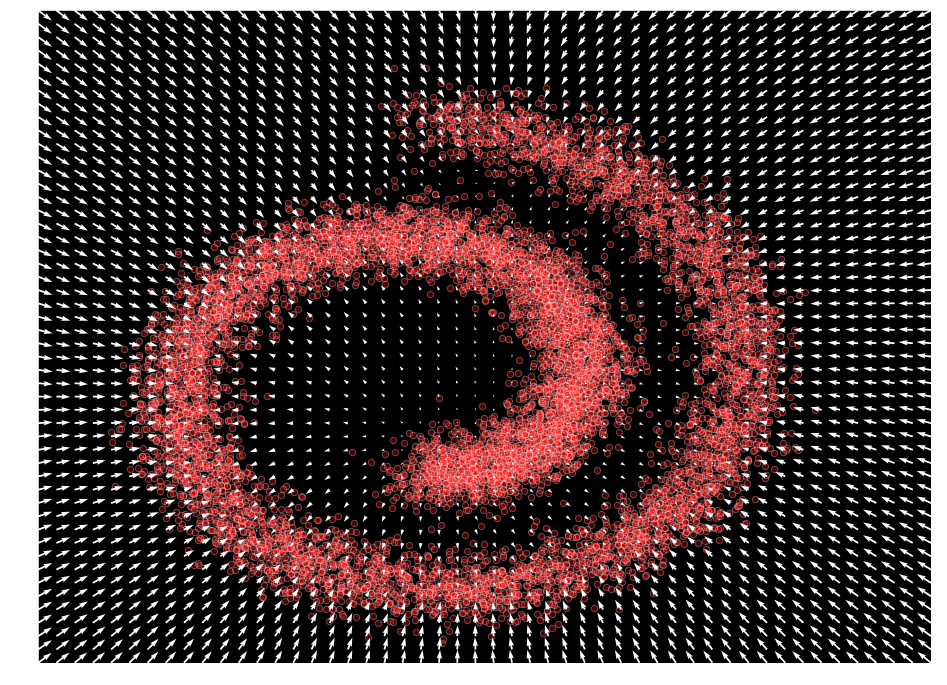

In [14]:
plot_gradients(model, data)

## 参考

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

## 其他资源

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb

https://github.com/ermongroup/sliced_score_matching